In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/pronostico_dataset.csv', delimiter=';')

In [ ]:
if 'ID' in df.columns:
    df.drop(columns=['ID'], inplace=True)

In [ ]:
# Converting categorical target variable to numeric
df['prognosis'] = df['prognosis'].map({'retinopathy': 1, 'no_retinopathy': 0})

In [ ]:
X = df.drop(columns=['prognosis'])
y = df['prognosis']

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBoost

capturing complex patterns in the data through the combination of weak learners

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:49:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Initial Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Initial Model Performance:
Accuracy: 0.7417
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       583
           1       0.75      0.75      0.75       617

    accuracy                           0.74      1200
   macro avg       0.74      0.74      0.74      1200
weighted avg       0.74      0.74      0.74      1200



Hyperparameter Tuning


In [ ]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  #to balance between speed and accuracy.
    'learning_rate': [0.01, 0.1, 0.2], #to explore slow, moderate, and fast learning rates.
    'max_depth': [3, 5, 7], #to balance simplicity and complexity.
    'subsample': [0.6, 0.8, 1.0]
}

In [ ]:
random_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                                   param_grid, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:51:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Get best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [ ]:
# Train best model
xgb_best = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:51:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predictions with optimized model
y_pred_optimized = xgb_best.predict(X_test_scaled)

In [ ]:
# Evaluate optimized model
print("Optimized Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(classification_report(y_test, y_pred_optimized))

Optimized Model Performance:
Accuracy: 0.7608
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       583
           1       0.77      0.77      0.77       617

    accuracy                           0.76      1200
   macro avg       0.76      0.76      0.76      1200
weighted avg       0.76      0.76      0.76      1200



###Deployment

In [ ]:
import pickle

# Save model
with open("xgb_model.pkl", "wb") as model_file:
    pickle.dump(xgb_best, model_file)
print("XGBoost model saved successfully!")

XGBoost model saved successfully!


In [ ]:
# Visualizing the decision boundary for first two principal components
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Reducing feature dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [ ]:
# Retraining model on reduced features
xgb_best_pca = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_best_pca.fit(X_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:52:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

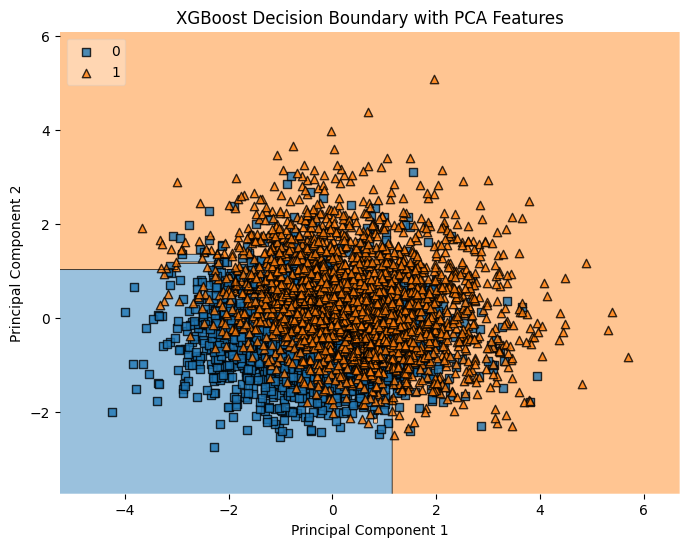

In [ ]:
# Plot decision boundary
plt.figure(figsize=(8, 6))
plot_decision_regions(X_train_pca, y_train.to_numpy(), clf=xgb_best_pca, legend=2)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("XGBoost Decision Boundary with PCA Features")
plt.show()
